In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, coherent_unitary_error

from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeBrooklynV2

# from qiskit.quantum_info import Kraus, SuperOp

# Import from Qiskit Aer noise module
# import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import GetGHZCircuitsForModel
from circuits.pqc_circuits import qiskit_PQC_RZRX_unique
from circuits.modify_circuits import append_pqc_to_quantum_circuit

from models.noise_models import BitPhaseFlipNoise
from models.qiskit_models import ScaledQiskitQuantumModel

from simulator.simulate import get_ideal_data, get_ideal_data_superpos

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 25

ideal_sim = AerSimulator(device=aer_device)

pqc_arch = qiskit_PQC_RZRX_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = ScaledQiskitQuantumModel(
    num_params=NUM_QUBITS*2, simulator=ideal_sim, num_shots=NUM_SHOTS, pqc_arch_func=pqc_arch, use_regularization=True
)

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
)



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=int(10000), device=aer_device)
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:16<00:00, 598.60it/s]

32


In [9]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.float().to(torch_device)
        measured = measured.float().to(torch_device)

        # Compute fidelity loss
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out
        reg_loss = pqc_model.regularization_loss(lam=lambda_reg)
        total_loss = loss + reg_loss

        total_loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(total_loss.item())

        data_iterator.set_postfix_str(f"Loss: {total_loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            bounded = pqc_model.get_bounded_params().detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.append(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

    


 Starting Epoch 1


  0%|          | 13/10000 [00:00<03:35, 46.31it/s, Loss: 8.3048e+03]

	Step 0, grad norm: 1.5680e-02
	Raw param range: [-5.456, 1.789]
	Bounded param range: [-3.105, 3.067]


100%|██████████| 10000/10000 [02:05<00:00, 79.63it/s, Loss: 1.1686e+03]


Epoch 1 complete: avg loss = 2.0584e+03

 Starting Epoch 2


  0%|          | 13/10000 [00:00<01:21, 123.28it/s, Loss: 2.4856e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.000, 0.002]


100%|██████████| 10000/10000 [01:54<00:00, 87.01it/s, Loss: 6.8364e+03]


Epoch 2 complete: avg loss = 1.9213e+03

 Starting Epoch 3


  0%|          | 9/10000 [00:00<01:54, 87.15it/s, Loss: 6.3150e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.000, 0.003]


100%|██████████| 10000/10000 [01:58<00:00, 84.55it/s, Loss: 4.0600e+03]


Epoch 3 complete: avg loss = 1.9219e+03

 Starting Epoch 4


  0%|          | 13/10000 [00:00<01:20, 124.25it/s, Loss: 3.5013e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.141]
	Bounded param range: [-0.002, 0.002]


100%|██████████| 10000/10000 [01:59<00:00, 83.90it/s, Loss: 5.9362e+02]


Epoch 4 complete: avg loss = 1.9251e+03

 Starting Epoch 5


  0%|          | 8/10000 [00:00<02:19, 71.52it/s, Loss: 5.6869e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.000, 0.002]


100%|██████████| 10000/10000 [01:58<00:00, 84.67it/s, Loss: 6.5256e+02]


Epoch 5 complete: avg loss = 1.9258e+03

 Starting Epoch 6


  0%|          | 7/10000 [00:00<02:33, 64.94it/s, Loss: 8.2825e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.001, 0.001]


100%|██████████| 10000/10000 [02:22<00:00, 70.21it/s, Loss: 2.5300e+02]


Epoch 6 complete: avg loss = 1.9228e+03

 Starting Epoch 7


  0%|          | 7/10000 [00:00<02:23, 69.46it/s, Loss: 2.6444e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.141]
	Bounded param range: [-0.001, 0.002]


100%|██████████| 10000/10000 [02:23<00:00, 69.80it/s, Loss: 1.8774e+03]


Epoch 7 complete: avg loss = 1.9252e+03

 Starting Epoch 8


  0%|          | 7/10000 [00:00<02:23, 69.53it/s, Loss: 1.2152e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.001, 0.009]


100%|██████████| 10000/10000 [02:24<00:00, 69.23it/s, Loss: 7.1034e+03]


Epoch 8 complete: avg loss = 1.9277e+03

 Starting Epoch 9


  0%|          | 7/10000 [00:00<02:40, 62.14it/s, Loss: 1.1177e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.000, 0.002]


100%|██████████| 10000/10000 [02:21<00:00, 70.61it/s, Loss: 7.0084e+03]


Epoch 9 complete: avg loss = 1.9247e+03

 Starting Epoch 10


  0%|          | 8/10000 [00:00<02:18, 72.11it/s, Loss: 1.2344e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.141]
	Bounded param range: [-0.000, 0.001]


100%|██████████| 10000/10000 [02:23<00:00, 69.74it/s, Loss: 2.4744e+02]


Epoch 10 complete: avg loss = 1.9237e+03

 Starting Epoch 11


  0%|          | 8/10000 [00:00<02:20, 70.91it/s, Loss: 3.6281e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.003, 0.002]


100%|██████████| 10000/10000 [02:21<00:00, 70.50it/s, Loss: 7.8806e+02]


Epoch 11 complete: avg loss = 1.9269e+03

 Starting Epoch 12


  0%|          | 8/10000 [00:00<02:22, 70.09it/s, Loss: 1.7856e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.141]
	Bounded param range: [-0.001, 0.002]


100%|██████████| 10000/10000 [02:21<00:00, 70.88it/s, Loss: 1.0353e+03]


Epoch 12 complete: avg loss = 1.9225e+03

 Starting Epoch 13


  0%|          | 8/10000 [00:00<02:21, 70.38it/s, Loss: 1.1992e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.001, 0.000]


100%|██████████| 10000/10000 [02:22<00:00, 70.38it/s, Loss: 4.9054e+03]


Epoch 13 complete: avg loss = 1.9230e+03

 Starting Epoch 14


  0%|          | 8/10000 [00:00<02:05, 79.42it/s, Loss: 7.9694e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.002, 0.003]


100%|██████████| 10000/10000 [02:21<00:00, 70.92it/s, Loss: 3.5329e+03]


Epoch 14 complete: avg loss = 1.9240e+03

 Starting Epoch 15


  0%|          | 7/10000 [00:00<02:28, 67.51it/s, Loss: 2.2764e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.141]
	Bounded param range: [-0.000, 0.003]


100%|██████████| 10000/10000 [02:23<00:00, 69.62it/s, Loss: 5.2800e+02]


Epoch 15 complete: avg loss = 1.9252e+03

 Starting Epoch 16


  0%|          | 7/10000 [00:00<02:33, 64.93it/s, Loss: 1.2491e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.000, 0.002]


100%|██████████| 10000/10000 [02:21<00:00, 70.47it/s, Loss: 9.7369e+02]


Epoch 16 complete: avg loss = 1.9254e+03

 Starting Epoch 17


  0%|          | 7/10000 [00:00<02:36, 64.00it/s, Loss: 4.5642e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.004, 0.001]


100%|██████████| 10000/10000 [02:19<00:00, 71.63it/s, Loss: 1.1201e+03]


Epoch 17 complete: avg loss = 1.9237e+03

 Starting Epoch 18


  0%|          | 8/10000 [00:00<02:17, 72.45it/s, Loss: 3.0656e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.003, 0.002]


100%|██████████| 10000/10000 [02:22<00:00, 70.05it/s, Loss: 7.1733e+03]


Epoch 18 complete: avg loss = 1.9221e+03

 Starting Epoch 19


  0%|          | 7/10000 [00:00<02:32, 65.70it/s, Loss: 2.3148e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.000, 0.001]


100%|██████████| 10000/10000 [02:20<00:00, 71.24it/s, Loss: 1.2144e+03]


Epoch 19 complete: avg loss = 1.9244e+03

 Starting Epoch 20


  0%|          | 8/10000 [00:00<02:21, 70.42it/s, Loss: 4.4456e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.002, 0.000]


100%|██████████| 10000/10000 [02:22<00:00, 70.16it/s, Loss: 3.6203e+03]


Epoch 20 complete: avg loss = 1.9216e+03

 Starting Epoch 21


  0%|          | 8/10000 [00:00<02:25, 68.85it/s, Loss: 1.8944e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.141]
	Bounded param range: [-0.002, 0.001]


100%|██████████| 10000/10000 [02:20<00:00, 71.01it/s, Loss: 1.9583e+03]


Epoch 21 complete: avg loss = 1.9235e+03

 Starting Epoch 22


  0%|          | 9/10000 [00:00<02:03, 80.82it/s, Loss: 1.3581e+02]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.001, 0.001]


100%|██████████| 10000/10000 [02:19<00:00, 71.85it/s, Loss: 4.8788e+02]


Epoch 22 complete: avg loss = 1.9256e+03

 Starting Epoch 23


  0%|          | 8/10000 [00:00<02:22, 70.09it/s, Loss: 5.1404e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.141]
	Bounded param range: [-0.002, 0.002]


100%|██████████| 10000/10000 [02:23<00:00, 69.69it/s, Loss: 3.3006e+02]


Epoch 23 complete: avg loss = 1.9250e+03

 Starting Epoch 24


  0%|          | 8/10000 [00:00<02:24, 69.26it/s, Loss: 1.5681e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.001, 0.001]


100%|██████████| 10000/10000 [02:21<00:00, 70.52it/s, Loss: 2.2362e+03]


Epoch 24 complete: avg loss = 1.9262e+03

 Starting Epoch 25


  0%|          | 7/10000 [00:00<02:35, 64.32it/s, Loss: 2.0006e+03]

	Step 0, grad norm: 3.1416e-02
	Raw param range: [-6.283, 3.142]
	Bounded param range: [-0.001, 0.001]


100%|██████████| 10000/10000 [02:22<00:00, 70.38it/s, Loss: 2.3638e+03]

Epoch 25 complete: avg loss = 1.9265e+03


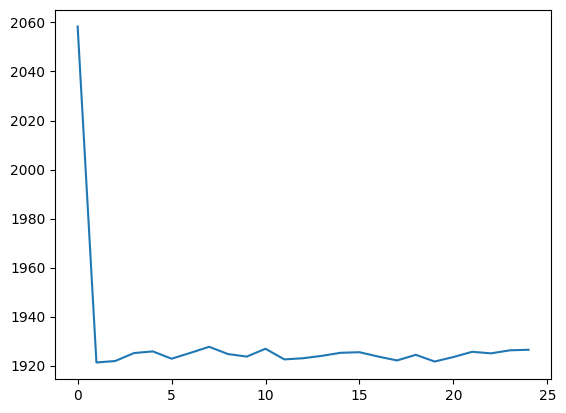

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
param_arr = np.array(param_list_epoch).transpose()
print(param_arr)

[[[-6.2831688e+00 -6.2831788e+00 -6.2831864e+00 ... -6.2823429e+00
   -6.2834301e+00 -6.2832074e+00]
  [-6.2831688e+00 -6.2831788e+00 -6.2831864e+00 ... -6.2823429e+00
   -6.2834301e+00 -6.2832074e+00]
  [-6.2831688e+00 -6.2831788e+00 -6.2831864e+00 ... -6.2823429e+00
   -6.2834301e+00 -6.2832074e+00]
  ...
  [-6.2831688e+00 -6.2831788e+00 -6.2831864e+00 ... -6.2823429e+00
   -6.2834301e+00 -6.2832074e+00]
  [-6.2831688e+00 -6.2831788e+00 -6.2831864e+00 ... -6.2823429e+00
   -6.2834301e+00 -6.2832074e+00]
  [-6.2831688e+00 -6.2831788e+00 -6.2831864e+00 ... -6.2823429e+00
   -6.2834301e+00 -6.2832074e+00]]

 [[-3.1415813e+00 -3.1415877e+00 -3.1409299e+00 ... -3.1416347e+00
   -3.1418555e+00 -3.1415517e+00]
  [-3.1415813e+00 -3.1415877e+00 -3.1409299e+00 ... -3.1416347e+00
   -3.1418555e+00 -3.1415517e+00]
  [-3.1415813e+00 -3.1415877e+00 -3.1409299e+00 ... -3.1416347e+00
   -3.1418555e+00 -3.1415517e+00]
  ...
  [-3.1415813e+00 -3.1415877e+00 -3.1409299e+00 ... -3.1416347e+00
   -3.1418

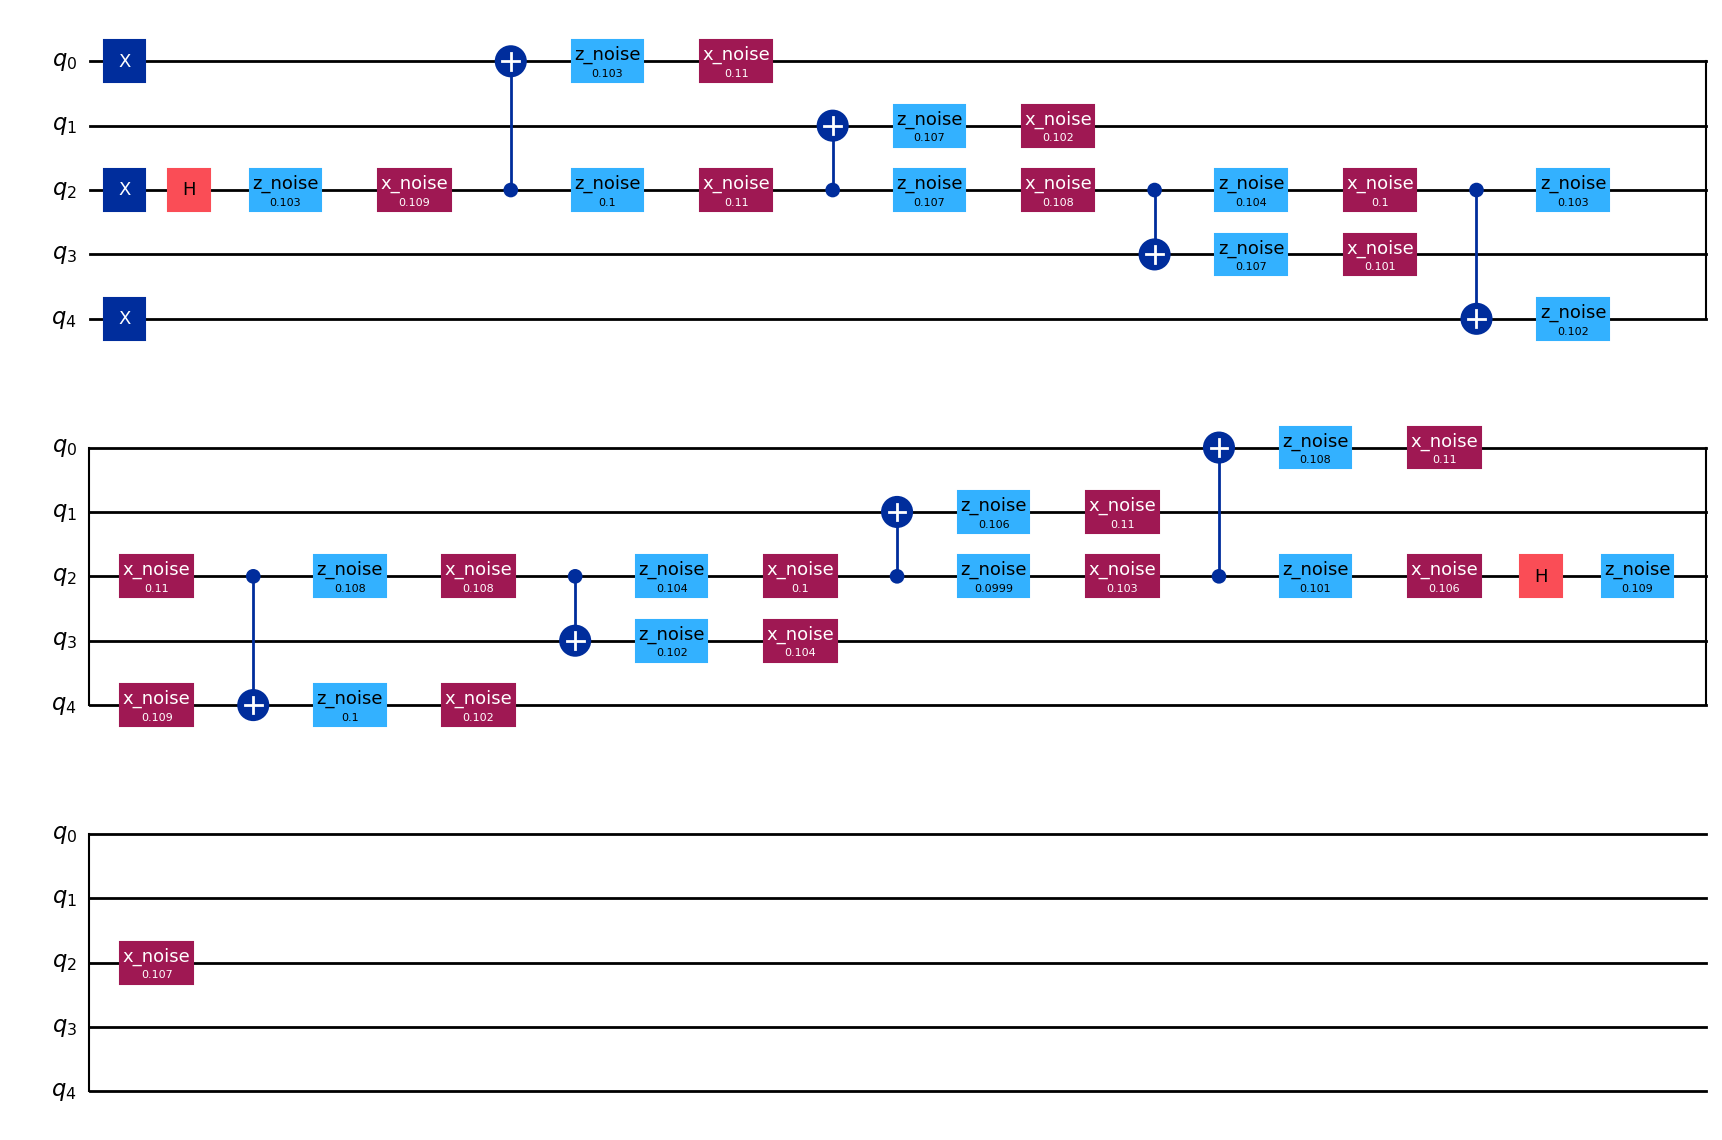

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

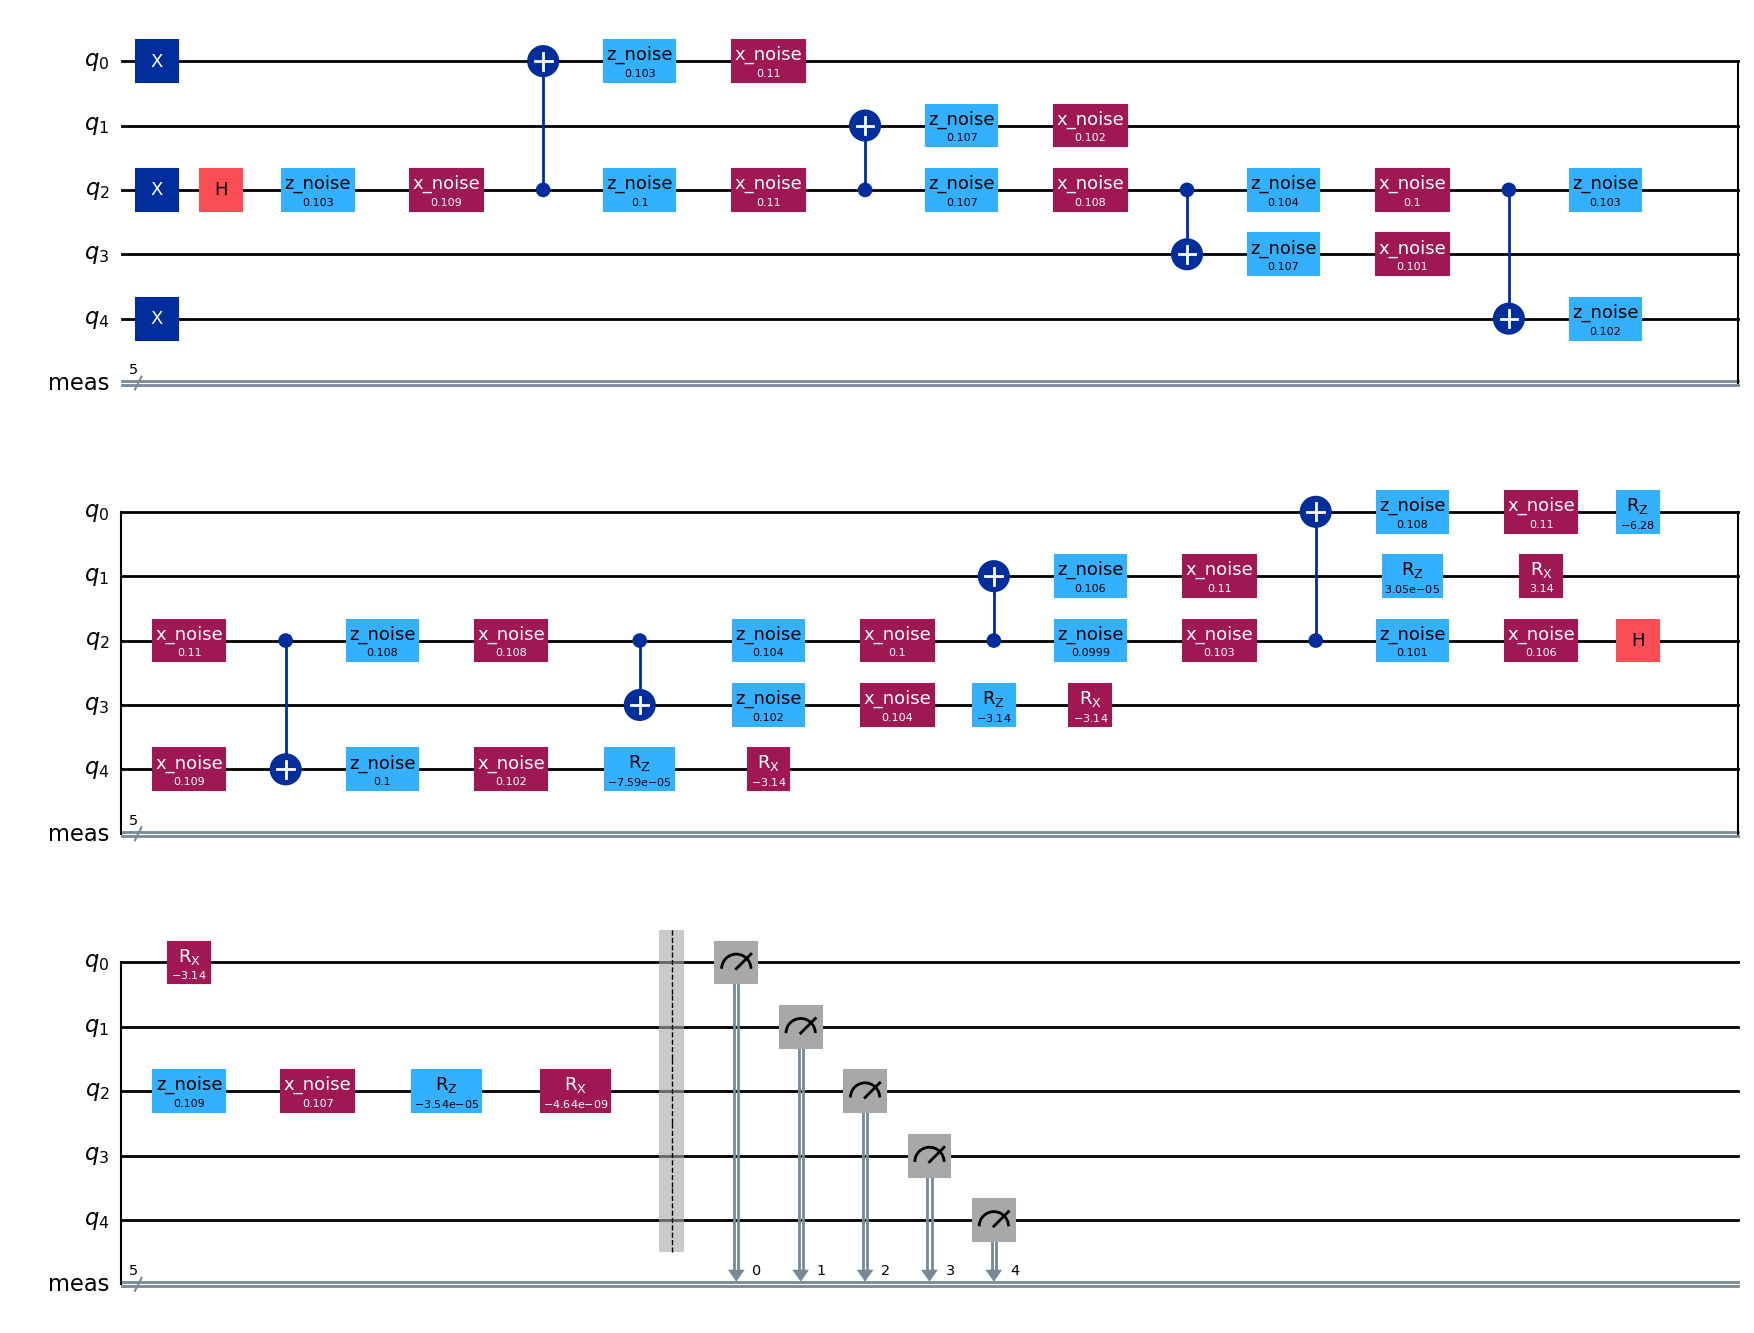

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, pqc_arch)
noisy_model_circ_pqc.draw('mpl')

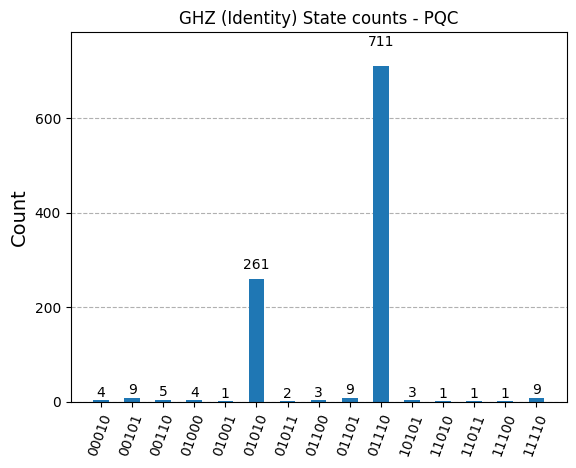

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

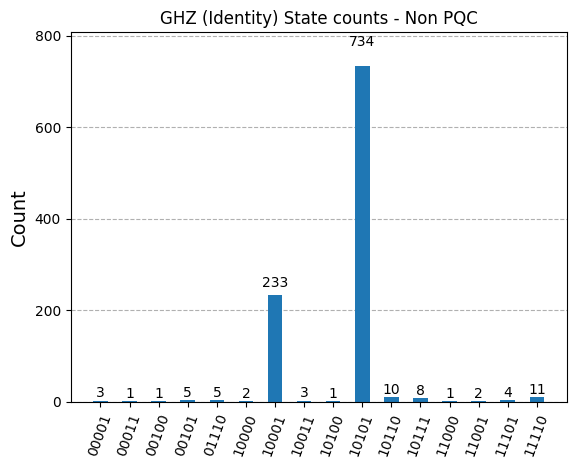

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

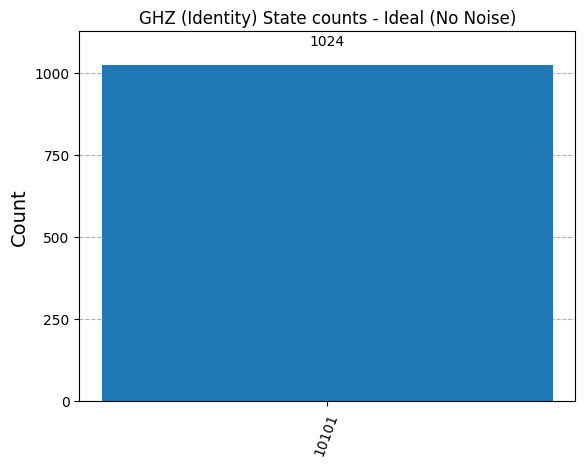

In [16]:
transpiled_circ = transpile(ghz_circuit_gen.get_ideal_model_circuit(INPUT_BITS).measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Ideal (No Noise)')

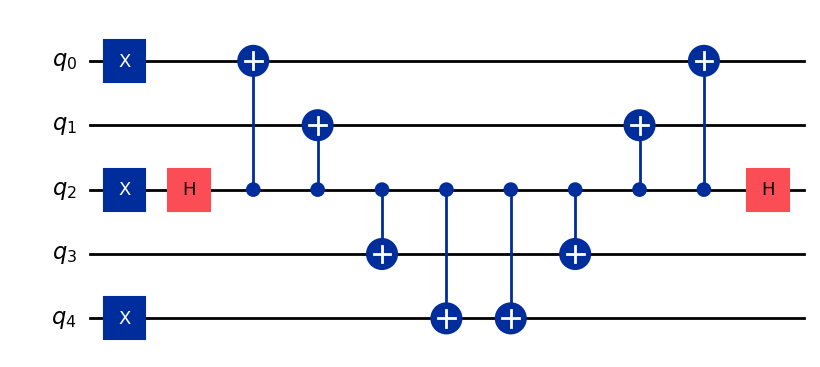

In [17]:
ghz_circuit_gen.get_ideal_model_circuit(INPUT_BITS).draw('mpl')

In [18]:
from simulator.simulate import run_circuit_sampler

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def fidelity(p, q):
    return torch.square(torch.sqrt(p * q).sum())

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=20)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, pqc_arch)

    counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    prob_i = counts_to_probs(ideal)
    prob_n = counts_to_probs(counts_noisy)
    prob_ne = counts_to_probs(counts_noisy_pqc)

    fid_i_n = fidelity(prob_i, prob_n)
    fid_i_ne = fidelity(prob_i, prob_ne)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 622.17it/s]


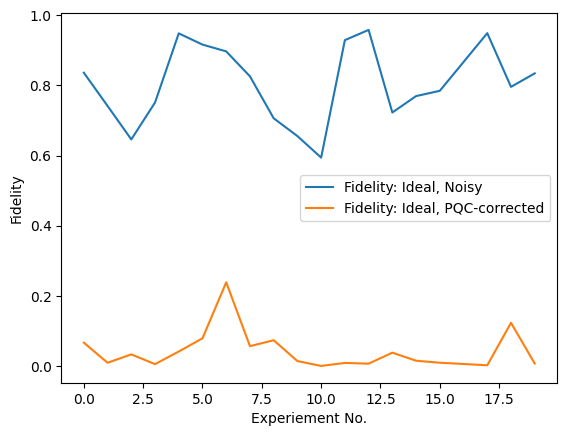

In [19]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [20]:
torch.save(pqc_model.state_dict(), f'../data/torch_models/{str(pqc_model.__str__())}_state_dict.pth')

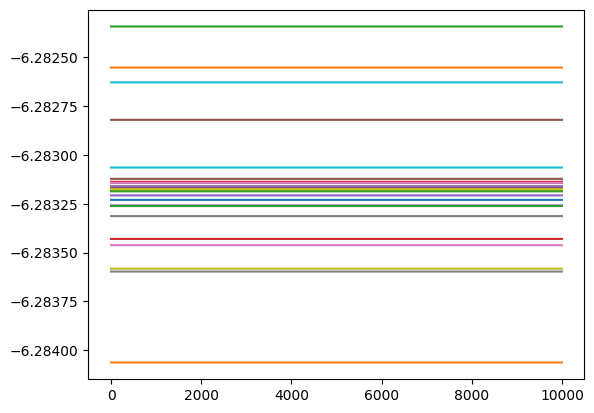

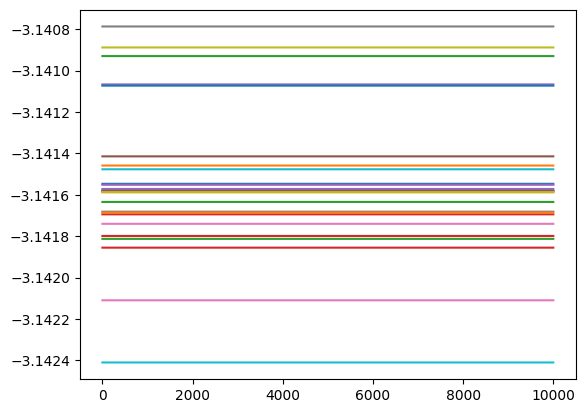

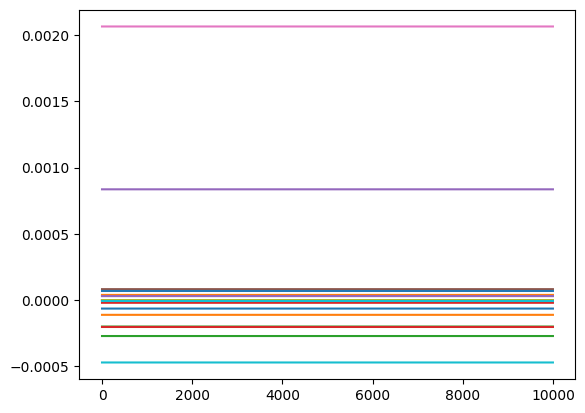

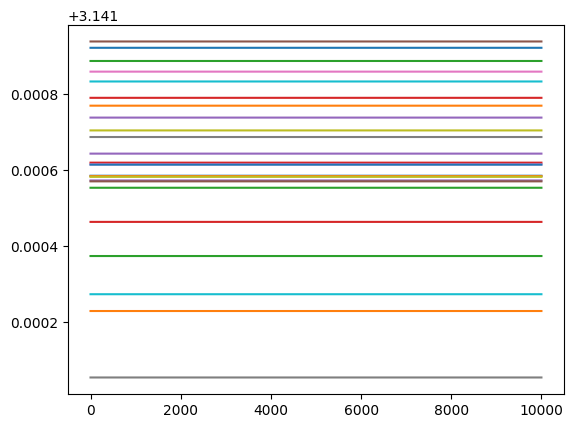

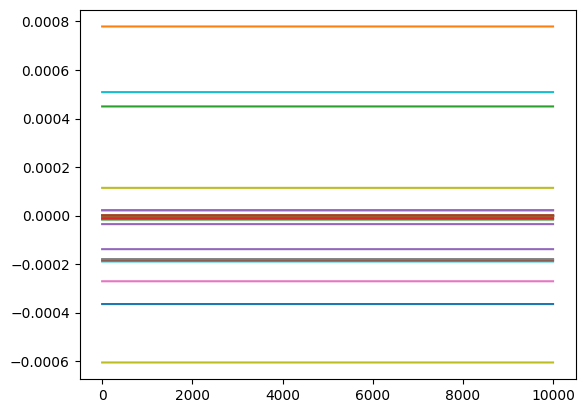

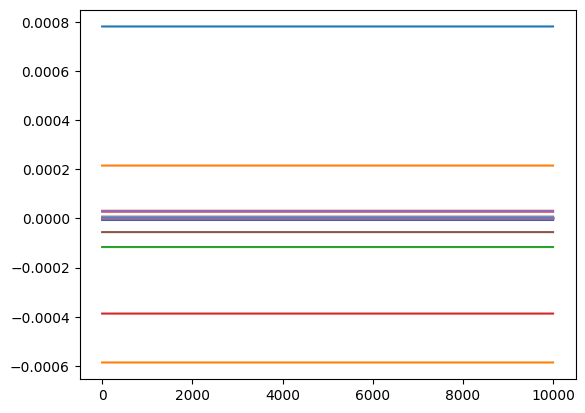

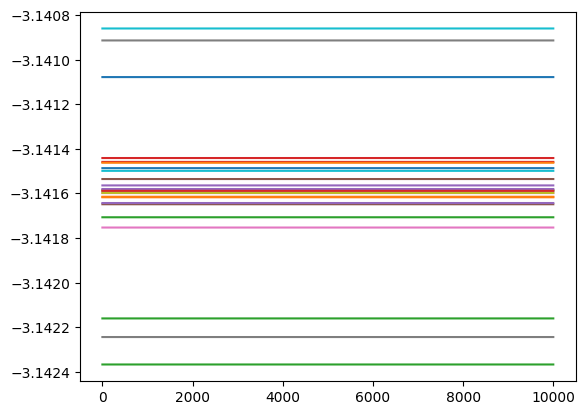

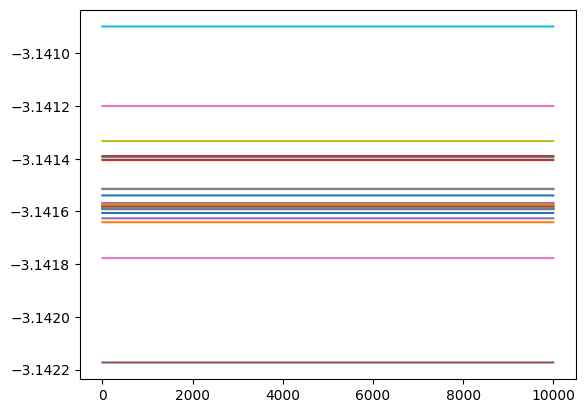

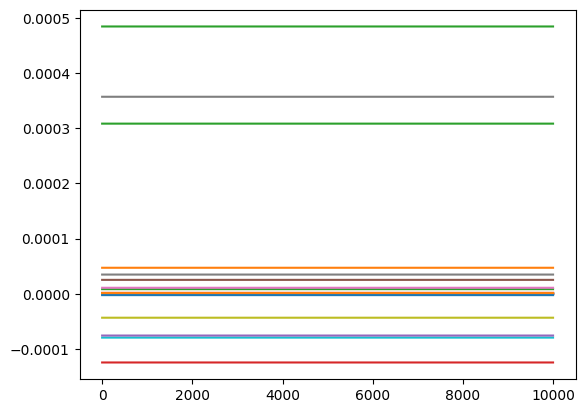

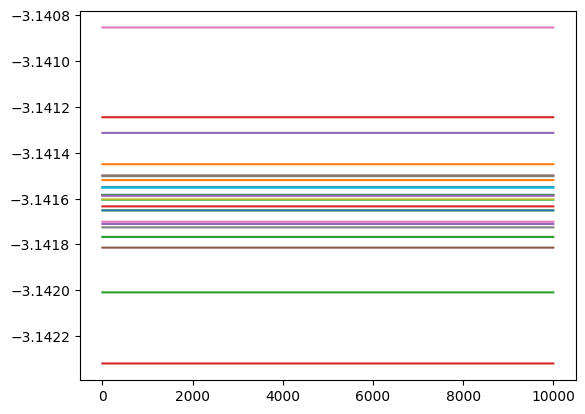

In [21]:
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()